In [106]:
#libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [107]:
data1 = pd.read_csv('train.csv')
data2 = pd.read_csv('test.csv')
data3 = pd.read_csv('Exam_Score_Prediction.csv')

train_df = data1.copy()
test_df = data2.copy()
previous_df = data3.copy()

print("First 5 rows of train data: \n", train_df.head())
print("First 5 rows of test data: \n", test_df.head())

First 5 rows of train data: 
    id  age  gender   course  study_hours  class_attendance internet_access  \
0   0   21  female     b.sc         7.91              98.8              no   
1   1   18   other  diploma         4.95              94.8             yes   
2   2   20  female     b.sc         4.68              92.6             yes   
3   3   19    male     b.sc         2.00              49.5             yes   
4   4   23    male      bca         7.65              86.9             yes   

   sleep_hours sleep_quality   study_method facility_rating exam_difficulty  \
0          4.9       average  online videos             low            easy   
1          4.7          poor     self-study          medium        moderate   
2          5.8          poor       coaching            high        moderate   
3          8.3       average    group study            high        moderate   
4          9.6          good     self-study            high            easy   

   exam_score  
0        7

In [108]:
sleep_map = {
    "poor": 0.5,
    "average": 1,
    "good": 1.5

}

facility_map = {
    "low": 0,
    "medium": 1,
    "high": 2
}

difficulty_map = {
    "hard": 0,
    "moderate": 1,
    "easy": 2
}

method_map = {
    "self-study": 0,
    "online videos": 1,
    "group study": 2,
    "mixed": 3,
    "coaching": 4
}

train_df['sleep_quality'] = train_df['sleep_quality'].map(sleep_map)
test_df['sleep_quality'] = test_df['sleep_quality'].map(sleep_map)

train_df['facility_rating'] = train_df['facility_rating'].map(facility_map)
test_df['facility_rating'] = test_df['facility_rating'].map(facility_map)

train_df['exam_difficulty'] = train_df['exam_difficulty'].map(difficulty_map)
test_df['exam_difficulty'] = test_df['exam_difficulty'].map(difficulty_map)

train_df['study_method'] = train_df['study_method'].map(method_map)
test_df['study_method'] = test_df['study_method'].map(method_map)

In [109]:
#dropping course

train_df = train_df.drop(columns='course')
test_df = test_df.drop(columns='course')

In [110]:
gender_map = {
    "other": "female",
    "male": "male",
    "female": "female"
}

train_df['gender'] = train_df['gender'].map(gender_map)
test_df['gender'] = test_df['gender'].map(gender_map)

In [111]:
train_df_encoded = pd.get_dummies(train_df, columns=['gender', 'internet_access'], drop_first= True)
test_df_encoded = pd.get_dummies(test_df, columns=['gender', 'internet_access'], drop_first= True)

In [112]:
train_df_encoded.head()

,id,age,study_hours,class_attendance,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,gender_male,internet_access_yes
0,0,21,7.91,98.8,4.9,1.0,1,0,2,78.3,False,False
1,1,18,4.95,94.8,4.7,0.5,0,1,1,46.7,False,True
2,2,20,4.68,92.6,5.8,0.5,4,2,1,99.0,False,True
3,3,19,2.00,49.5,8.3,1.0,2,2,1,63.9,True,True
4,4,23,7.65,86.9,9.6,1.5,0,2,2,100.0,True,True


In [113]:
def find_inefficient_studiers_correct(df):
    """Find students who study a lot but score poorly compared to OTHER high-study students"""
    
    # 1. identify high study
    study_75th = df['study_hours'].quantile(0.75)
    high_study_mask = df['study_hours'] > study_75th
    high_study_df = df[high_study_mask].copy()
    
    print(f"High-study students (>{study_75th:.1f} hours): {len(high_study_df)}")
    print(f"Their score distribution:")
    print(high_study_df['exam_score'].describe())
    
    # 2. test score for the group
    high_study_25th = high_study_df['exam_score'].quantile(0.25)
    print(f"\n25th percentile AMONG HIGH-STUDY students: {high_study_25th:.1f}")
    
    # 3. creating the mask
    suspicious_mask = high_study_mask & (df['exam_score'] < high_study_25th)
    
    print(f"\nHigh-study, low-score students: {suspicious_mask.sum()}")
    
    if suspicious_mask.sum() > 0:
        print("\nThese students study a lot but score poorly (compared to other high-study students):")
        print(df[suspicious_mask][['study_hours', 'exam_score']].head())
    
    return suspicious_mask

In [114]:
corrected_mask = find_inefficient_studiers_correct(train_df_encoded)

High-study students (>6.0 hours): 156730
Their score distribution:
count    156730.000000
mean         81.177432
std          12.169366
min          21.600000
25%          72.600000
50%          81.500000
75%          90.800000
max         100.000000
Name: exam_score, dtype: float64

25th percentile AMONG HIGH-STUDY students: 72.6

High-study, low-score students: 39115

These students study a lot but score poorly (compared to other high-study students):
     study_hours  exam_score
56          7.91        70.9
96          7.69        60.7
108         7.45        62.9
110         6.38        68.4
145         7.85        69.3


In [115]:
study_hours = 'study_hours'

train_df_encoded[f'{study_hours}_adjusted'] = np.where(
    corrected_mask,
    train_df_encoded[study_hours] * 0.7,  # Reducing by 30%
    train_df_encoded[study_hours]
)

print(f"Adjusted study hours for {corrected_mask.sum()} students")
print("\nBefore adjustment stats:")
print(train_df_encoded[study_hours].describe())
print("\nAfter adjustment stats:")
print(train_df_encoded[f'{study_hours}_adjusted'].describe())

Adjusted study hours for 39115 students

Before adjustment stats:
count    630000.000000
mean          4.002337
std           2.359880
min           0.080000
25%           1.970000
50%           4.000000
75%           6.050000
max           7.910000
Name: study_hours, dtype: float64

After adjustment stats:
count    630000.000000
mean          3.874047
std           2.251152
min           0.080000
25%           1.970000
50%           4.000000
75%           5.580000
max           7.910000
Name: study_hours_adjusted, dtype: float64


In [116]:
train_df_encoded['study_hours'] = train_df_encoded['study_hours_adjusted']

In [117]:
train_df_encoded = train_df_encoded.drop(columns='study_hours_adjusted')

In [118]:
#compressing class_attendancy

train_df_encoded['class_attendance'] = np.where(
    train_df_encoded['class_attendance'] > 98,
    98 + (train_df_encoded['class_attendance'] - 98)* 0.3,
    train_df_encoded['class_attendance']
)

test_df_encoded['class_attendance'] = np.where(
    test_df_encoded['class_attendance'] > 98,
    98 + (test_df_encoded['class_attendance'] - 98)* 0.3,
    test_df_encoded['class_attendance']
)



In [120]:
#train test split

from sklearn.model_selection import train_test_split

X = train_df_encoded.drop(columns='exam_score')
y = train_df_encoded['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [122]:
#regression issues

def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Linear Regression" : LinearRegression(),
        "Random Forest" : RandomForestRegressor(),
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df, model

In [123]:
results_df, best_model = train_and_eval_models(X_train, X_test, y_train, y_test)

print(results_df)

Starting the training process.
Training model: Linear Regression
Training model: Random Forest
Training model: XGB

Model Performance Summary:
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   6.931498  6.908503    8.698516   8.668903  0.788959   
1      Random Forest   2.557856  6.881557    3.247872   8.657576  0.970578   
2                XGB   6.573082  6.686260    8.258137   8.395689  0.809787   

    Test R2  
0  0.789058  
1  0.789608  
2  0.802144  
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   6.931498  6.908503    8.698516   8.668903  0.788959   
1      Random Forest   2.557856  6.881557    3.247872   8.657576  0.970578   
2                XGB   6.573082  6.686260    8.258137   8.395689  0.809787   

    Test R2  
0  0.789058  
1  0.789608  
2  0.802144  


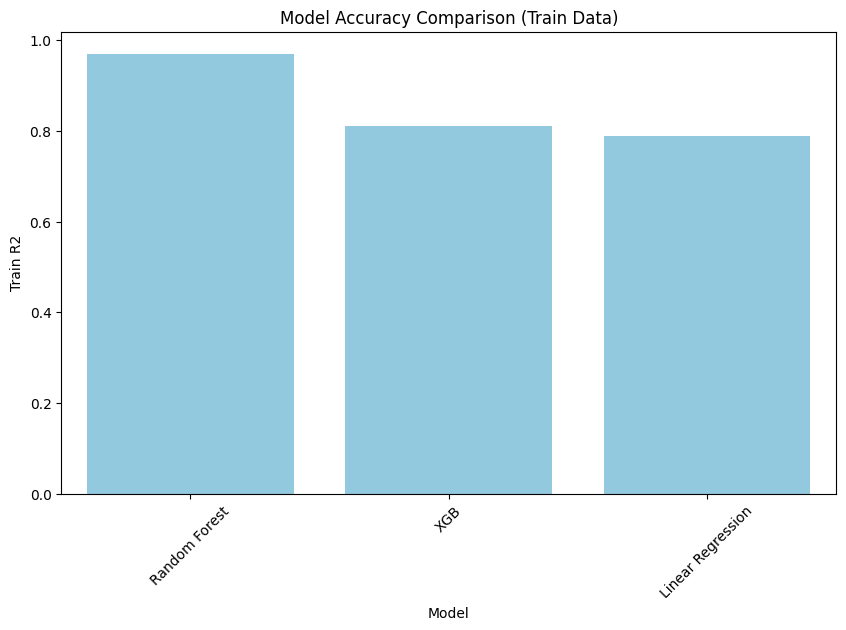

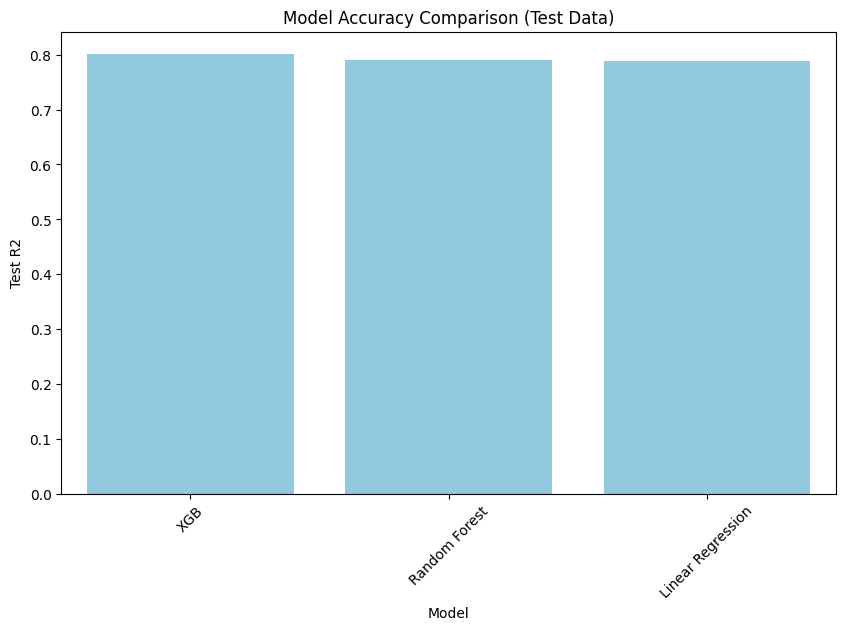

In [124]:
#plotting the results

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Train R2", data=results_df.sort_values(by='Train R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Train Data)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R2", data=results_df.sort_values(by='Test R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Test Data)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# X_submission = test_df_encoded.copy()

# y_pred = best_model.predict(X_submission)

# submission_df = pd.DataFrame({
#     'id' : test_df_encoded['id'],
#     'exam_score' : y_pred
# })

# submission_df.to_csv("submission4.csv", index= False)

# print("Success!")

Success!
